In [1]:
import pandas as pd
import numpy as np
import missingno as msno
from plotnine import *
import matplotlib.pyplot as plt
import warnings
import math
warnings.filterwarnings("ignore")

# For pre-processing data 
from sklearn import preprocessing as pp 
from sklearn.compose import ColumnTransformer 

# For splits and CV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold # Cross validation 
from sklearn.model_selection import cross_validate # Cross validation 
from sklearn.model_selection import GridSearchCV # Cross validation + param. tuning.

# Machine learning methods 
from sklearn.linear_model import LinearRegression as LM
from sklearn.neighbors import KNeighborsRegressor as KNN
from sklearn.tree import DecisionTreeRegressor as DTree
from sklearn import tree # For plotting the decision tree rules
from sklearn.ensemble import BaggingRegressor as Bag
from sklearn.ensemble import RandomForestRegressor as RF
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor

# For evaluating our model's performance
import sklearn.metrics as metrics

# Pipeline to combine modeling elements
from sklearn.pipeline import Pipeline

In [2]:
train_data = pd.read_csv('train_data.csv') #reading in training data set
train_data.shape

(43590, 39)

In [3]:
train_data.head()
#https://dcdatahub.maps.arcgis.com/sharing/rest/content/items/c5fb3fbe4c694a59a6eef7bf5f8bc49a/info/metadata/metadata.xml?format=default&output=html

,OBJECTID,SSL,BATHRM,HF_BATHRM,HEAT,HEAT_D,AC,NUM_UNITS,ROOMS,BEDRM,...,ROOF,ROOF_D,INTWALL,INTWALL_D,KITCHENS,FIREPLACES,USECODE,LANDAREA,GIS_LAST_MOD_DTTM,LN_PRICE
0,78021,4061N 0085,3.0,1.0,1.0,Forced Air,Y,1.0,9.0,4.0,...,2.0,Built Up,6.0,Hardwood,1.0,0.0,11,2234,2018-07-22T18:01:43.000Z,13.591116
1,28783,1587 0075,2.0,1.0,7.0,Warm Cool,Y,1.0,7.0,3.0,...,11.0,Slate,6.0,Hardwood,1.0,1.0,12,3850,2018-07-22T18:01:43.000Z,12.730801
2,35035,2024 0817,2.0,2.0,13.0,Hot Water Rad,Y,1.0,9.0,4.0,...,11.0,Slate,6.0,Hardwood,1.0,1.0,12,7866,2018-07-22T18:01:43.000Z,13.651814
3,67983,3736 0059,1.0,1.0,7.0,Warm Cool,Y,1.0,6.0,3.0,...,2.0,Built Up,6.0,Hardwood,1.0,0.0,13,2739,2018-07-22T18:01:43.000Z,12.860999
4,8791,0817 0826,2.0,0.0,13.0,Hot Water Rad,N,1.0,11.0,4.0,...,6.0,Metal- Sms,6.0,Hardwood,1.0,0.0,11,2097,2018-07-22T18:01:43.000Z,14.100690


## PRE-PROCESSING

- We see that YR_RMDL has the maximum number of missing values. 
- But these null values could be meaningful, in a way that the null values indicate that those houses haven't been remodelled.
- A way to think about it is that remodelling before sale might increase the market price of an old house

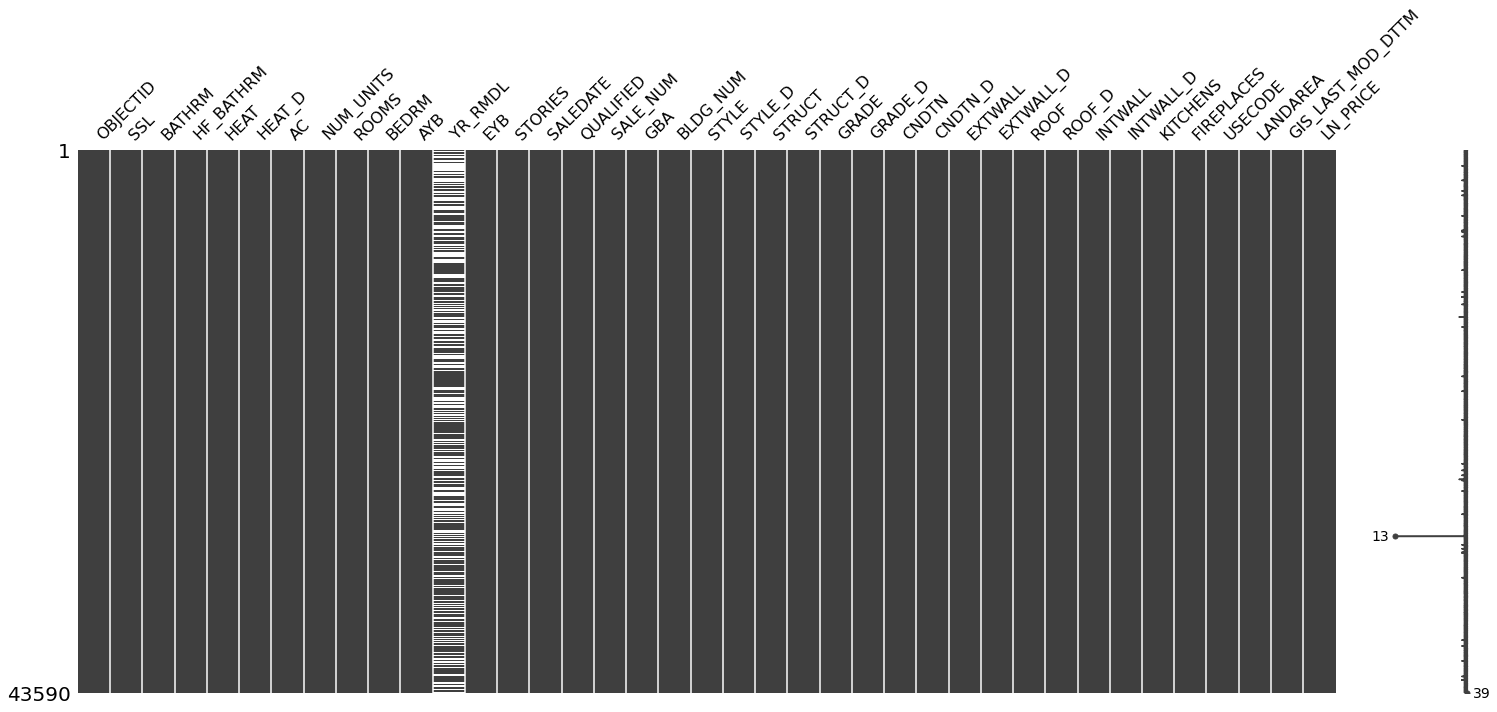

In [4]:
msno.matrix(train_data) 


- As there are barely any null values (compared to 45k observations) in  fields other than YR_RMDL, we can consider removing these observations (expcept for those in YR_RMDL),as it won't have a huge impact in terms of information loss.

In [5]:
train_data.isnull().sum() #Null vaues in each field


OBJECTID                 0
SSL                      0
BATHRM                   1
HF_BATHRM                2
HEAT                     1
HEAT_D                   1
AC                       1
NUM_UNITS                1
ROOMS                   11
BEDRM                    4
AYB                      4
YR_RMDL              18583
EYB                      0
STORIES                 29
SALEDATE                 0
QUALIFIED                0
SALE_NUM                 0
GBA                      0
BLDG_NUM                 0
STYLE                    1
STYLE_D                  1
STRUCT                   1
STRUCT_D                 1
GRADE                    1
GRADE_D                  1
CNDTN                    1
CNDTN_D                  1
EXTWALL                  1
EXTWALL_D                1
ROOF                     1
ROOF_D                   1
INTWALL                  1
INTWALL_D                1
KITCHENS                 2
FIREPLACES               1
USECODE                  0
LANDAREA                 0
G

In [6]:
train_data[['QUALIFIED','AYB','YR_RMDL','EYB','SALEDATE', 'CNDTN','BATHRM','HF_BATHRM', 'NUM_UNITS', 'ROOMS', 'LN_PRICE', 'HEAT', 'AC','LANDAREA','GRADE', 'STORIES']].sample(5)

,QUALIFIED,AYB,YR_RMDL,EYB,SALEDATE,CNDTN,BATHRM,HF_BATHRM,NUM_UNITS,ROOMS,LN_PRICE,HEAT,AC,LANDAREA,GRADE,STORIES
32242,Q,1977.0,NaN,1979,1998-01-07T00:00:00.000Z,3.0,1.0,2.0,1.0,6.0,11.218554,7.0,Y,1143,4.0,2.0
20025,Q,1925.0,2009.0,1967,2016-05-31T00:00:00.000Z,4.0,1.0,1.0,1.0,5.0,13.487006,1.0,Y,1183,4.0,2.0
38855,Q,1931.0,NaN,1964,2018-03-15T00:00:00.000Z,4.0,2.0,0.0,1.0,6.0,13.487006,13.0,N,1250,3.0,2.0
33123,U,1941.0,NaN,1943,1993-03-08T00:00:00.000Z,3.0,2.0,0.0,2.0,6.0,10.239960,13.0,N,870,3.0,2.0
8700,Q,1948.0,2013.0,1973,2017-10-24T00:00:00.000Z,3.0,2.0,2.0,1.0,9.0,13.681979,7.0,Y,5017,6.0,2.0


In [7]:
def preprocessing(data=train_data):
    
    '''
    This function tranforms DC Housing data.
    - Assigns 0, 1 to binary variables like 'QUALIFIED' and 'AC'
    - Creates new variable LYCR which signifies the 'Lastest Year of Construction or Remodelling'
      which in cmomparison with SALES YEAR is used as a predictor
    - Truncates entries in fields like 'SSL' and 'SALEDATE' to have the desired predictors
    
    '''
    data['SSL']=data.SSL.str[-4:]#Lot of property can be used to predict price. As price depends on location as well
    data['QUALIFIED'] = [ 1 if i=="Q" else 0for i in data['QUALIFIED'] ] #Binary variable
    data = data[data['AC'].notna()] #As 'AC' has NAs
    data['AC'] = [ 1 if i=="Y" else 0 for i in data['AC'] ]#Binary variable
    data['SALEYEAR'] = data['SALEDATE'].str[0:4] #Sale year - seperating last four characters
    data['SALEYEAR'] = data['SALEYEAR'].astype(int) #Converting SALEYEAR to integer
    
    LYCR =[] #Creating new variable which signifies the 'Lastest Year of Construction or Remodelling'
    for index, row in data.iterrows(): #Interating over rows
        
        if math.isnan(row['YR_RMDL']): # if the house hasn't been remodelled, we assign LYCR the value of AYB
            LYCR.append(row['AYB'])    # which is actual year builty
        else:
            LYCR.append(row['YR_RMDL']) # If it has been remodelled, it capture that year
    data["LYCR"] = LYCR #Assigning the list created as a variable to the data frame
        
    #AYB or remodelling - sale year -> If a house has been remodelled before sale, 
    #it is a reasonable assumption that the sales price will be higher
    data['SALEYEAR_LYCR_diff'] = data["LYCR"] - data["SALEYEAR"]
    
    #Subsetting only the desired variables
    data = data[~data[['QUALIFIED', 'CNDTN','BATHRM','HF_BATHRM',\
                                         'NUM_UNITS', 'ROOMS', 'LN_PRICE', 'HEAT', 'AC',\
                                         'GRADE', 'STORIES', 'SALEYEAR_LYCR_diff', 'SSL','LANDAREA']].isna()]

                                         
                                         
    data = data[['QUALIFIED', 'CNDTN','BATHRM','HF_BATHRM', 'NUM_UNITS'\
                             , 'ROOMS', 'LN_PRICE', 'HEAT', 'AC', 'GRADE', 'STORIES',\
                             'SALEYEAR_LYCR_diff', 'SSL','LANDAREA']]
    data['Ln_LANDAREA'] = np.log(data['LANDAREA']) #As Landarea is skewed we apply log transformation
    
    data = data[~data.isin([np.nan, np.inf, -np.inf]).any(1)]
    # Remove the observations which are not finite
    
    return (data)

preprocessed_train_data = preprocessing(train_data)
y_train = preprocessed_train_data['LN_PRICE'] # log selling price
X_train = preprocessed_train_data[['QUALIFIED', 'CNDTN','BATHRM','HF_BATHRM',\
                      'NUM_UNITS', 'ROOMS', 'HEAT', 'AC', 'GRADE', 'STORIES',\
                      'SALEYEAR_LYCR_diff', 'SSL','Ln_LANDAREA']] # Predictors

In [8]:
X_train.head() #Our Predictors

,QUALIFIED,CNDTN,BATHRM,HF_BATHRM,NUM_UNITS,ROOMS,HEAT,AC,GRADE,STORIES,SALEYEAR_LYCR_diff,SSL,Ln_LANDAREA
0,1,5.0,3.0,1.0,1.0,9.0,1.0,1,5.0,2.0,-1.0,0085,7.711549
1,1,5.0,2.0,1.0,1.0,7.0,7.0,1,6.0,2.0,-56.0,0075,8.255828
2,0,3.0,2.0,2.0,1.0,9.0,13.0,1,6.0,2.5,-7.0,0817,8.970305
3,1,3.0,1.0,1.0,1.0,6.0,7.0,1,3.0,2.0,-63.0,0059,7.915348
4,1,3.0,2.0,0.0,1.0,11.0,13.0,0,5.0,2.0,-11.0,0826,7.648263


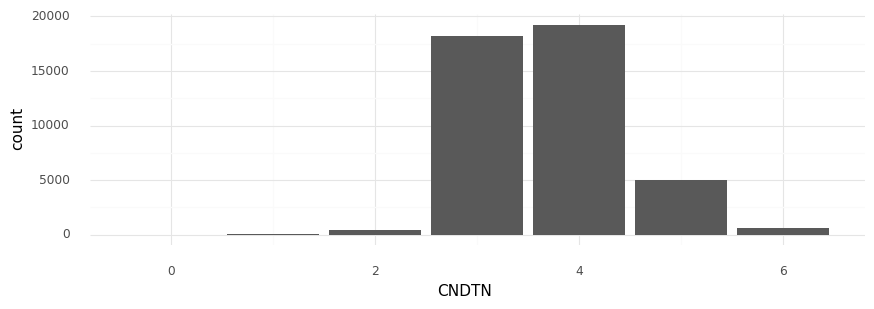

<ggplot: (190053200887)>

In [9]:
#We iteratively check the distribution of all predictors to assess which standardizing method could be used
( 
    ggplot(X_train,aes(x='CNDTN')) +
    geom_bar() +
    theme_minimal() +
    theme(figure_size = (10,3)) 
)

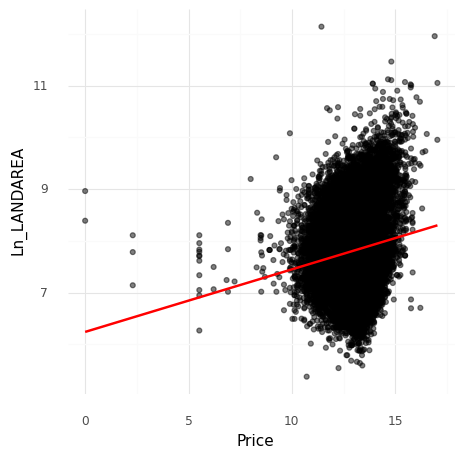

<ggplot: (190060068602)>

In [11]:
train_data =X_train.copy()
train_data['Price']=y_train
(
    ggplot(train_data,
           aes(y='Ln_LANDAREA',x='Price'))+
    geom_point(alpha=.5) +
    geom_smooth(method="lm",se=False,color="red") +
    theme_minimal() +
    theme(figure_size = (5,5)) 
)

In [12]:
# (1) kfold method for cross validation
fold_generator = KFold(n_splits=5, shuffle=True,random_state=111)

# (2) Using a StandardScaler for Preprocessing
preprocess = ColumnTransformer(transformers=[('num', pp.StandardScaler(), ['QUALIFIED',\
'CNDTN','BATHRM','HF_BATHRM', 'NUM_UNITS', 'ROOMS', 'HEAT', 'AC', 'GRADE', 'STORIES', 'SALEYEAR_LYCR_diff', 'SSL','Ln_LANDAREA'])])


# (3) Model pipeline
pipe = Pipeline(steps=[('pre_process', preprocess),
                       ('model',None)])


# (4) Specify the models  and their repsective tuning parameters. 
# Note the naming convention here to reference the model key
search_space = [
    # Linear Model
    {'model' : [LM()]},
    
    # KNN with K tuning param
    {'model' : [KNN()],
     'model__n_neighbors':[10,15,20,25]},
    
    # Decision Tree with the Max Depth Param
    {'model': [DTree()],
     'model__max_depth':[1,2,3,4,5]},
    
    # The Bagging decision tree model 
    {'model': [Bag()]},
    
    # Random forest with the N Estimator
    {'model' : [RF()],
     'model__max_depth':[1,2,3,4],
     'model__n_estimators':[500,1000,1250]},
    
    {
        'model' : [XGBRegressor()], #gradient descent decision tree algorithm
        'model__max_depth':[1,2,3,4]}
]


# (5) Put it all together in the grid search
search = GridSearchCV(pipe, search_space, 
                      cv = fold_generator,
                      scoring='neg_mean_squared_error',
                      n_jobs=4)


In [13]:
#6) Fit the model to the training data
search.fit(X_train,y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=111, shuffle=True),
             estimator=Pipeline(steps=[('pre_process',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['QUALIFIED',
                                                                          'CNDTN',
                                                                          'BATHRM',
                                                                          'HF_BATHRM',
                                                                          'NUM_UNITS',
                                                                          'ROOMS',
                                                                          'HEAT',
                                                                          'AC',
                                  

In [14]:
search.best_params_

{'model': XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=4,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None),
 'model__max_depth': 4}

In [15]:
search.best_score_

-0.2983615705399103

## TEST PERFORMANCE

In [16]:
test_data = pd.read_csv("test_data.csv") #importing test data

In [17]:
preprocessed_test_data = preprocessing(test_data)#running the preprocessing function on test data 
y_test = preprocessed_test_data['LN_PRICE'] 
X_test = preprocessed_test_data[['QUALIFIED', 'CNDTN','BATHRM','HF_BATHRM',\
                      'NUM_UNITS', 'ROOMS', 'HEAT', 'AC', 'GRADE', 'STORIES',\
                      'SALEYEAR_LYCR_diff', 'SSL','Ln_LANDAREA']] predictors

In [18]:
pred_y = search.predict(X_test) #Predictions

In [19]:
metrics.mean_squared_error(y_test,pred_y) #Mean squared error

0.2852276228947003

In [20]:
metrics.r2_score(y_test,pred_y)

0.613998805630994

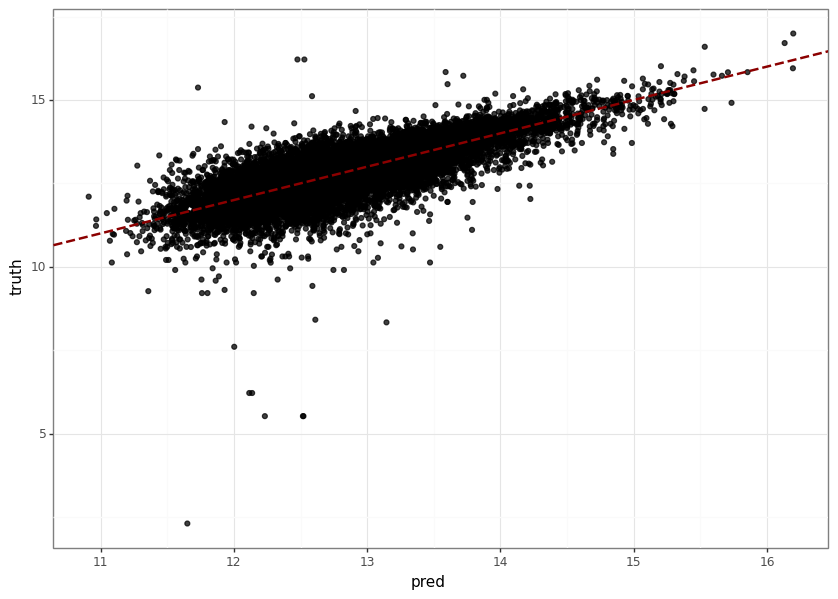

<ggplot: (190065344961)>

In [21]:
(
    ggplot(pd.DataFrame(dict(pred=pred_y,truth=y_test)),
          aes(x='pred',y="truth")) +
    geom_point(alpha=.75) +
    geom_abline(linetype="dashed",color="darkred",size=1) +
    theme_bw() +
    theme(figure_size=(10,7))
)

### The mean square error of our model (XGBRegressor) on the test data set is 0.285